# Model Training 

In this notebook, we train and compare multiple machine learning models to detect fraudulent transactions.

The goal is to identify the best-performing model based on relevant evaluation metrics, especially those suited for imbalanced classification problems.

### Models to be tested:
- Logistic Regression (baseline)
- Random Forest
- XGBoost

### Key evaluation metrics:
- **Recall**: prioritizes the detection of frauds (minimize false negatives)
- **AUC-ROC**: overall model quality in distinguishing between classes

We will train the models using the preprocessed training set, validate on the dev set, and preserve the test set for final evaluation.


In [43]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    recall_score,
    precision_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import load_processed_data
from src.upload_model_utils import save_model


## Load processed data

In [3]:
train_df = load_processed_data(split="train")
val_df = load_processed_data(split="val")

X_train = train_df.drop(columns=["Class"])
y_train = train_df["Class"]

X_val = val_df.drop(columns=["Class"])
y_val = val_df["Class"]


## Logistic Regression (baseline)

We begin with a Logistic Regression model as a baseline. Despite its simplicity, it provides a valuable reference point for evaluating more complex models.

To handle the class imbalance, we apply `class_weight='balanced'`, which automatically adjusts the weight of each class inversely proportional to its frequency in the data.

In [7]:
logreg = LogisticRegression(class_weight='balanced', max_iter=10000, solver= 'saga', random_state=7)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_val)
y_proba = logreg.predict_proba(X_val)[:, 1] 

recall = recall_score(y_val, y_pred)
auc = roc_auc_score(y_val, y_proba)

print(f"Recall: {recall:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nClassification report:\n")
print(classification_report(y_val, y_pred, digits=4))


Recall: 0.8163
AUC-ROC: 0.9240

Classification report:

              precision    recall  f1-score   support

           0     0.9997    0.9715    0.9854     28432
           1     0.0471    0.8163    0.0891        49

    accuracy                         0.9713     28481
   macro avg     0.5234    0.8939    0.5372     28481
weighted avg     0.9980    0.9713    0.9839     28481



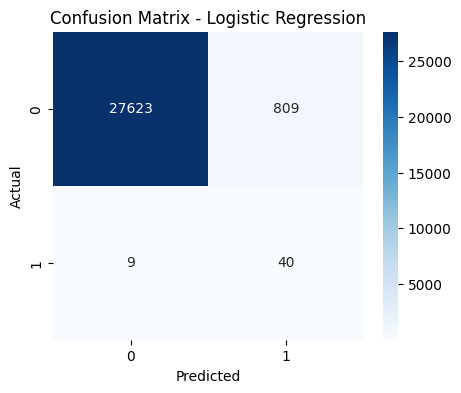

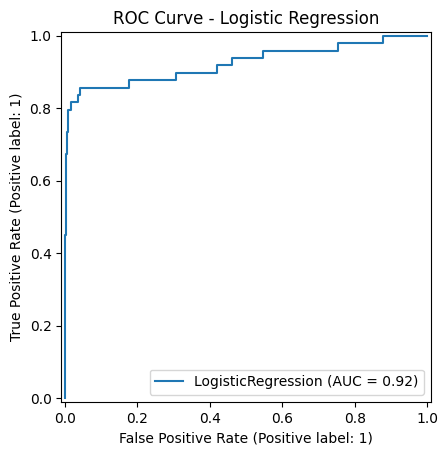

In [8]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

RocCurveDisplay.from_estimator(logreg, X_val, y_val)
plt.title("ROC Curve - Logistic Regression")
plt.show()


### Logistic Regression — Summary

The baseline logistic regression model achieved:

- **Recall (fraud class)**: 0.816 → detects most frauds
- **Precision (fraud class)**: 0.047 → many false positives
- **AUC-ROC**: 0.92 → strong class separation

Despite low precision, the high recall is desirable in fraud detection. This makes logistic regression a solid starting point for comparison, though more advanced models may improve precision and overall robustness.

## Random Forest

Now testing a Random Forest classifier with `class_weight='balanced'` to handle class imbalance.

In [12]:
rf = RandomForestClassifier(class_weight='balanced', n_estimators=600,n_jobs=-1, random_state=7)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
y_proba_rf = rf.predict_proba(X_val)[:, 1]

recall_rf = recall_score(y_val, y_pred_rf)
auc_rf = roc_auc_score(y_val, y_proba_rf)

print(f"Recall: {recall_rf:.4f}")
print(f"AUC-ROC: {auc_rf:.4f}")
print("\nClassification report:\n")
print(classification_report(y_val, y_pred_rf, digits=4))


Recall: 0.7143
AUC-ROC: 0.9653

Classification report:

              precision    recall  f1-score   support

           0     0.9995    1.0000    0.9998     28432
           1     1.0000    0.7143    0.8333        49

    accuracy                         0.9995     28481
   macro avg     0.9998    0.8571    0.9165     28481
weighted avg     0.9995    0.9995    0.9995     28481



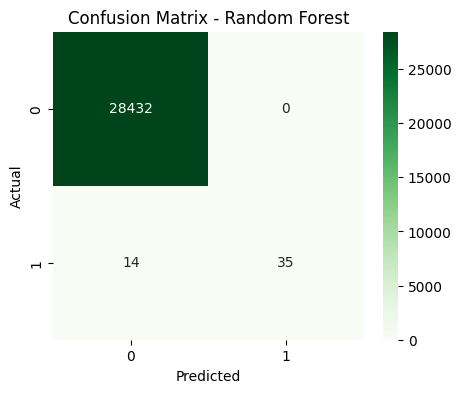

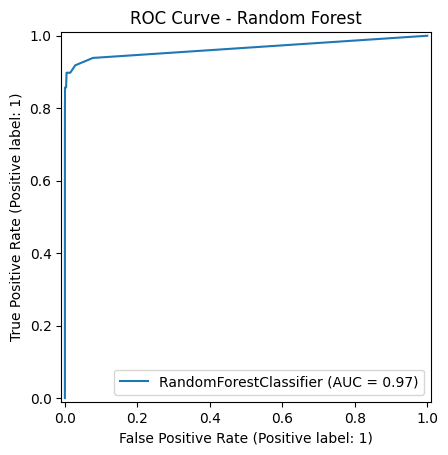

In [13]:
cm_rf = confusion_matrix(y_val, y_pred_rf)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

RocCurveDisplay.from_estimator(rf, X_val, y_val)
plt.title("ROC Curve - Random Forest")
plt.show()


### Random Forest (600 estimators)

- **Recall (fraud class)**: 0.714 → detected 71% of frauds
- **Precision (fraud class)**: 1.00 → no false positives
- **AUC-ROC**: 0.97 → excellent separation
- **F1-score (fraud)**: 0.83 → balanced performance

Compared to the baseline logistic model, Random Forest offers better balance between sensitivity and precision. A strong candidate for final tuning.

## XGBoost

Now testing an XGBoost classifier with `scale_pos_weight` to handle class imbalance.

In [20]:
warnings.filterwarnings("ignore", category=UserWarning) # Suppress harmless XGBoost warning about 'use_label_encoder' parameter to keep notebook clean
fraud_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb = XGBClassifier(
    n_estimators=300,
    scale_pos_weight=fraud_ratio,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=7
)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_val)
y_proba_xgb = xgb.predict_proba(X_val)[:, 1]

recall_xgb = recall_score(y_val, y_pred_xgb)
auc_xgb = roc_auc_score(y_val, y_proba_xgb)

print(f"Recall: {recall_xgb:.4f}")
print(f"AUC-ROC: {auc_xgb:.4f}")
print("\nClassification report:\n")
print(classification_report(y_val, y_pred_xgb, digits=4))


Recall: 0.7959
AUC-ROC: 0.9769

Classification report:

              precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     28432
           1     0.9750    0.7959    0.8764        49

    accuracy                         0.9996     28481
   macro avg     0.9873    0.8979    0.9381     28481
weighted avg     0.9996    0.9996    0.9996     28481



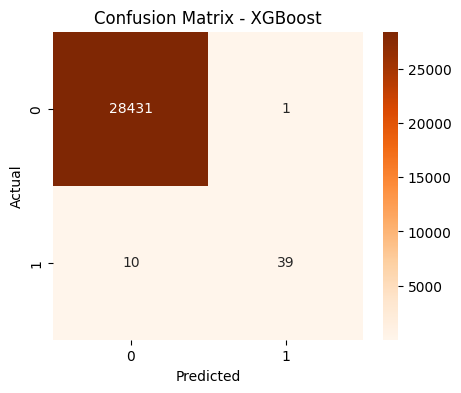

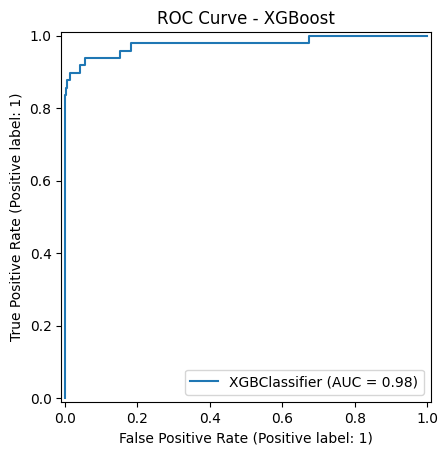

In [21]:
cm_xgb = confusion_matrix(y_val, y_pred_xgb)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_xgb, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

RocCurveDisplay.from_estimator(xgb, X_val, y_val)
plt.title("ROC Curve - XGBoost")
plt.show()


### XGBoost (300 estimators)

- **Recall (fraud class)**: 0.7959 → excellent detection
- **Precision (fraud class)**: 0.9750 → very low false positives
- **AUC-ROC**: 0.98 → highest so far
- **F1-score (fraud)**: 0.8764 → very balanced

XGBoost slightly outperforms Random Forest in both recall and AUC, while also training significantly faster.  
Given its superior performance and efficiency, XGBoost will be selected for hyperparameter tuning.


## Hyperparameter Tuning — RandomizedSearchCV

We start the optimization process using `RandomizedSearchCV` to explore a broad hyperparameter space for XGBoost.

This approach helps identify promising regions quickly without testing all combinations, which would be computationally expensive.

Once good ranges are found, we’ll refine the search using `GridSearchCV`.


In [24]:
param_dist = {
    "n_estimators": [200, 300, 400, 500],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

xgb_base = XGBClassifier(
    scale_pos_weight=fraud_ratio,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=7
)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist,
    n_iter=20,
    scoring="recall",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=7
)

random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print(f"Best recall: {random_search.best_score_:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best recall: 0.8427


## Hyperparameter Tuning — GridSearchCV (Refinement)

Based on the best results from the randomized search, we now refine the tuning using `GridSearchCV`.

This step explores a narrower hyperparameter space centered around the most promising configuration to further improve performance.

In [27]:
param_grid = {
    "n_estimators": [500, 600],
    "max_depth": [3, 4],
    "learning_rate": [0.03, 0.05, 0.07],
    "subsample": [0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9]
}

xgb_model = XGBClassifier(
    scale_pos_weight=fraud_ratio,
    use_label_encoder=False,
    eval_metric="logloss",
    n_jobs=-1,
    random_state=7
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="recall",
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best recall: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}
Best recall: 0.8579


## Tuned XGBoost Model

After refining the best region found by `RandomizedSearchCV`, we applied a focused `GridSearchCV` to further optimize performance.

- **Best Recall (CV)**: 0.8579
- **Best Parameters**:
  - `n_estimators`: 500
  - `max_depth`: 3
  - `learning_rate`: 0.03
  - `subsample`: 1.0
  - `colsample_bytree`: 0.7

This configuration will now be used to retrain the final model for evaluation.


Classification Report:

              precision    recall  f1-score   support

           0     0.9998    0.9964    0.9981     28432
           1     0.2966    0.8776    0.4433        49

    accuracy                         0.9962     28481
   macro avg     0.6482    0.9370    0.7207     28481
weighted avg     0.9986    0.9962    0.9971     28481



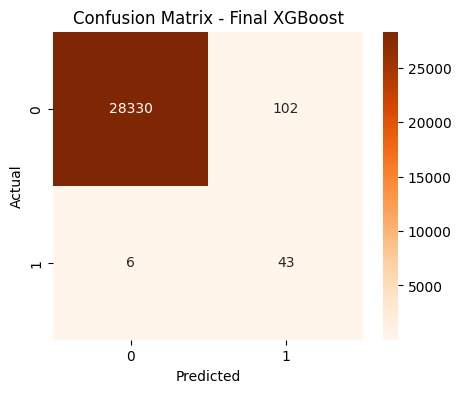

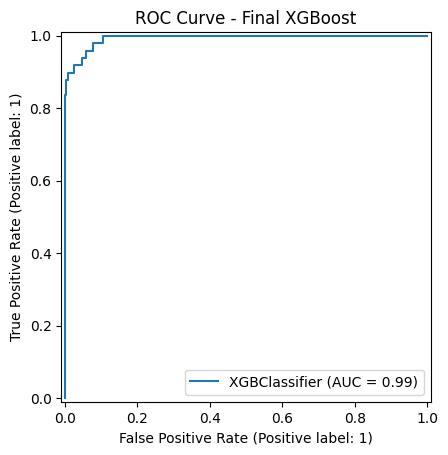

In [35]:
final_xgb = XGBClassifier(
    n_estimators=500,
    max_depth=3,
    learning_rate=0.03,
    subsample=1.0,
    colsample_bytree=0.7,
    scale_pos_weight=fraud_ratio,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1,
    random_state=7
)

final_xgb.fit(X_train, y_train)

y_pred_final = final_xgb.predict(X_val)
y_proba_final = final_xgb.predict_proba(X_val)[:, 1]

print("Classification Report:\n")
print(classification_report(y_val, y_pred_final, digits=4))

cm = confusion_matrix(y_val, y_pred_final)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - Final XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

RocCurveDisplay.from_estimator(final_xgb, X_val, y_val)
plt.title("ROC Curve - Final XGBoost")
plt.show()

### Model Performance Analysis and Next Step

The final XGBoost model, after hyperparameter tuning, achieved a strong recall of 0.8776 — meaning it correctly identified 43 out of 49 fraudulent transactions.

However,precision dropped to 0.2966, with 102 legitimate transactions misclassified as fraud.

This highlights a common trade-off in imbalanced classification problems:  
**increasing recall often reduces precision**, and vice versa.

Instead of retraining the model again, we will now adjust the **decision threshold** used to classify a transaction as fraud.  
By default, this threshold is 0.5, but tuning it allows us to better balance false positives and false negatives based on business needs.

We will explore multiple thresholds to visualize how precision and recall behave, and choose a value that offers a more favorable trade-off.


## Threshold Optimization

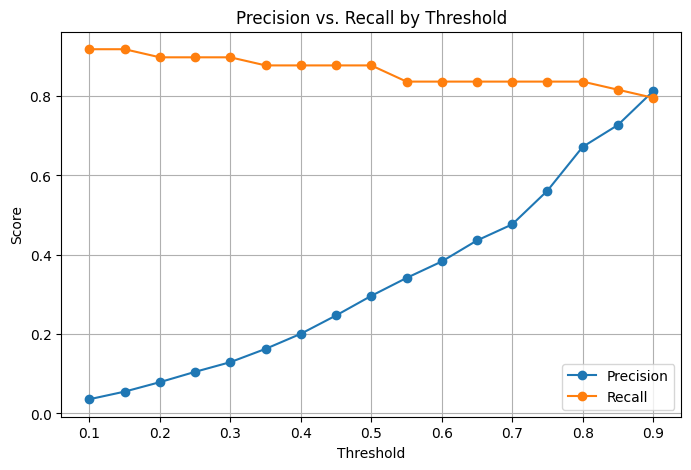

In [32]:
thresholds = np.linspace(0.1, 0.9, 17)
precisions = []
recalls = []

for t in thresholds:
    y_pred_t = (y_proba_final > t).astype(int)
    precisions.append(precision_score(y_val, y_pred_t))
    recalls.append(recall_score(y_val, y_pred_t))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions, label="Precision", marker="o")
plt.plot(thresholds, recalls, label="Recall", marker="o")
plt.title("Precision vs. Recall by Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


## Final Evaluation with Adjusted Threshold

Based on the Precision vs. Recall trade-off analysis, a threshold of 0.8 has been selected.

This value offers a more balanced performance:
- Significantly improved precision compared to the default 0.5
- Still maintains high recall, ensuring most frauds are detected

We now evaluate the model using this new threshold.

Evaluation using threshold = 0.8
              precision    recall  f1-score   support

           0     0.9997    0.9993    0.9995     28432
           1     0.6721    0.8367    0.7455        49

    accuracy                         0.9990     28481
   macro avg     0.8359    0.9180    0.8725     28481
weighted avg     0.9992    0.9990    0.9991     28481



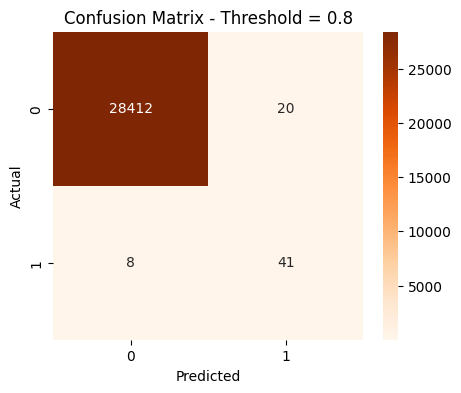

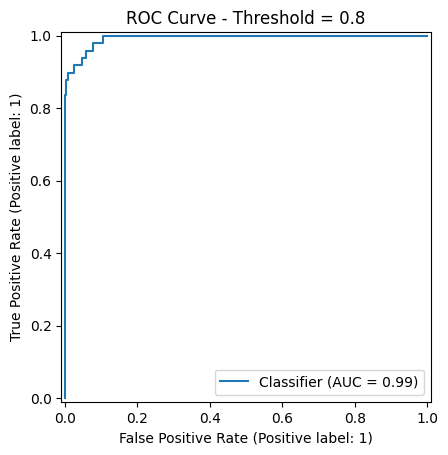

In [36]:
threshold = 0.8
y_pred_adjusted = (y_proba_final > threshold).astype(int)

print(f"Evaluation using threshold = {threshold}")
print(classification_report(y_val, y_pred_adjusted, digits=4))

cm_adj = confusion_matrix(y_val, y_pred_adjusted)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_adj, annot=True, fmt="d", cmap="Oranges")
plt.title(f"Confusion Matrix - Threshold = {threshold}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

RocCurveDisplay.from_predictions(y_val, y_proba_final)
plt.title(f"ROC Curve - Threshold = {threshold}")
plt.show()


## Final Model Selection and Evaluation

After testing multiple classification algorithms and applying hyperparameter tuning, the **XGBoost classifier** was selected as the final model. It consistently demonstrated strong performance in detecting fraudulent transactions across key evaluation metrics.

Initially, XGBoost with default threshold (0.5) achieved:

- **Precision (fraud class)**: 0.9750  
- **Recall (fraud class)**: 0.7959  
- **F1-score (fraud class)**: 0.8764  
- **False Negatives**: 10  
- **False Positives**: 1  
- **AUC-ROC**: 0.98  

Although the model was highly precise, it was overly conservative, missing 10 fraudulent cases.

---

### Threshold Adjustment: Finding a Better Trade-Off

To better balance fraud detection and false alarms, we analyzed the Precision-Recall trade-off over various thresholds.

A threshold of **0.8** was selected for its improved recall and more practical balance. With this adjustment:

- **Precision (fraud class)**: 0.6721  
- **Recall (fraud class)**: 0.8367  
- **F1-score (fraud class)**: 0.7455  
- **False Negatives**: 8  
- **False Positives**: 20  
- **AUC-ROC**: **0.99**

This trade-off offers a **higher recall** and **excellent overall separability**, while maintaining a reasonable precision. It is a more **operationally viable solution** in real-world fraud detection, where minimizing missed fraudulent cases is a critical priority.

---

### Final Remarks

- **Model selected**: Tuned XGBoost  
- **Threshold used**: 0.8  
- **Primary metric**: Recall  
- **Use-case focus**: Prioritizing fraud detection over occasional false alarms  


### Save the final model

In [44]:
save_model(final_xgb)